In [2]:
from salad.serialize import read, write
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import astropy.table
from tqdm import tqdm

In [3]:
measurements = list(Path("../search/tmp").rglob("cluster_*_forced.pkl"))
len(measurements)

66826

In [4]:
data = []
for path in tqdm(measurements):
    cluster_id = int(path.name.split("_")[1])
    snr = float(path.parent.parent.name.split("_")[1])
    detector = int(path.parent.parent.parent.name.split("_")[1])
    collection = path.parent.parent.parent.parent.relative_to(Path("../search/tmp"))
#     print(collection, detector, snr, cluster_id)
    try:
        d = read(str(path))
    except:
        pass
    mag = d.extra['measurement']['forced_mag']
#     d = read(path)
    data.append(
        dict(
            collection=collection,
            snr=snr,
            detector=detector,
            cluster=cluster_id,
            mag=np.nanmedian(mag),
            n=len(d.points),
            v_ra=d.extra['line'].beta[0, 0],
            v_dec=d.extra['line'].beta[0, 1],
        )
    )
    del d

  2%|▏         | 1448/66826 [00:13<04:42, 231.48it/s]/nvme/users/stevengs/opt_lsst/conda/envs/lsst-scipipe-8.0.0/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
100%|██████████| 66826/66826 [07:22<00:00, 151.01it/s]


In [5]:
data = astropy.table.Table(data)

In [6]:
def filter_velocity(data, vmin=0.1, vmax=0.5):
    v = (data['v_ra']**2 + data['v_dec']**2)**0.5
    return data[(v > vmin) & (v <= vmax)]

def filter_n(data, n=15):
    return data[data['n'] >= n]

In [18]:
filtered_data = filter_n(filter_velocity(data, vmin=0.05, vmax=0.55), n=25)
len(filtered_data)

4844

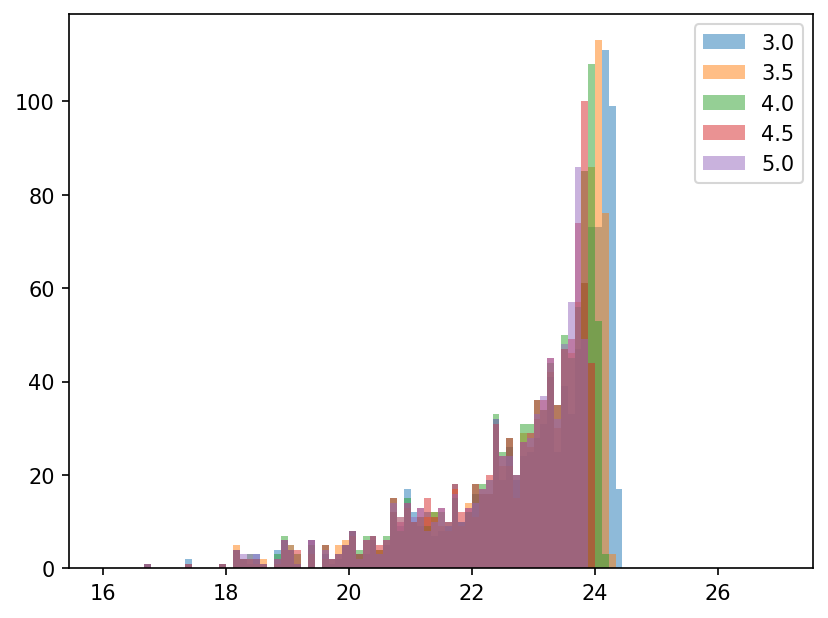

In [19]:
fig = plt.figure(dpi=150)
bins = np.linspace(16, 27, 100)
for group in filtered_data.group_by("snr").groups:
    plt.hist(group['mag'], bins=bins, label=group[0]['snr'], alpha=0.5)
# plt.hist(data['mag'], bins='auto', density=True, alpha=0.5)
plt.legend()
plt.show()

In [22]:
filtered_data[filtered_data['snr'] == 5]['mag'].max() - filtered_data[filtered_data['snr'] == 3]['mag'].max()

-0.5413210077410753

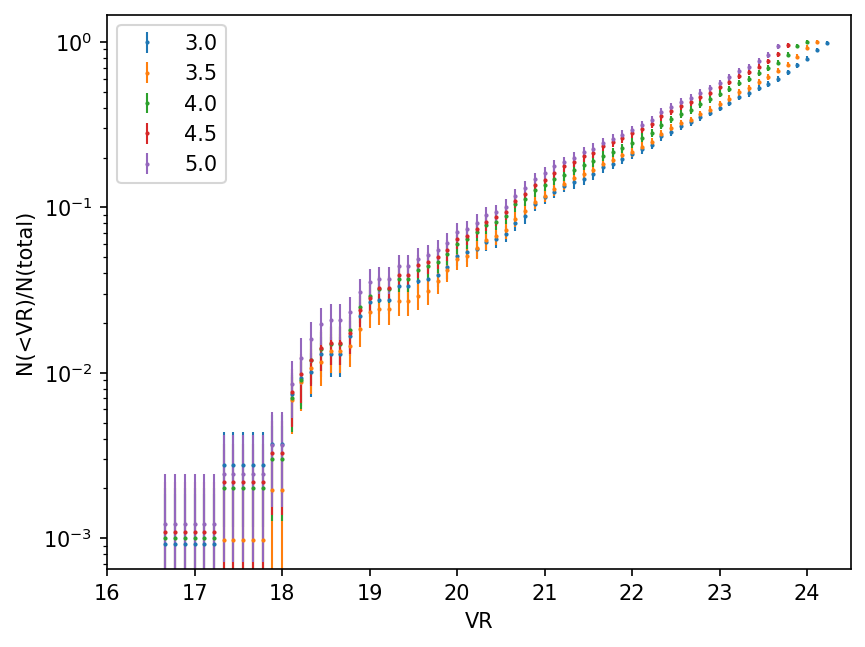

In [21]:
bins = np.linspace(16, 27, 100)

fig = plt.figure(dpi=150)
for d in filtered_data.group_by("snr").groups:
    snr = d[0]['snr']
#     d = filtered_data[filtered_data['snr'] == 3.0]
    n = []
    for i in range(len(bins) - 1):
        upper = bins[i + 1]
        lower = bins[i]
        mask = (d['mag'] < upper) & (d['mag'] >= lower)
        n.append(mask.sum())

    y = np.cumsum(n)/np.sum(n)
    yerr = np.sqrt(np.cumsum(n))/np.sum(n)
    mask = y < 1
#     mask[np.where(~mask)[0][0]] = True
    x = bins[:-1][mask]
    y = y[mask]
    yerr = yerr[mask]
    plt.errorbar(
        x, 
        y, 
        yerr=yerr, 
        ms=1, 
        lw=1, 
        fmt='o',
        label=snr
    )

plt.legend()
plt.yscale("log")
plt.xlim(16, 24.5)
plt.xlabel("VR")
plt.ylabel("N(<VR)/N(total)")
plt.show()

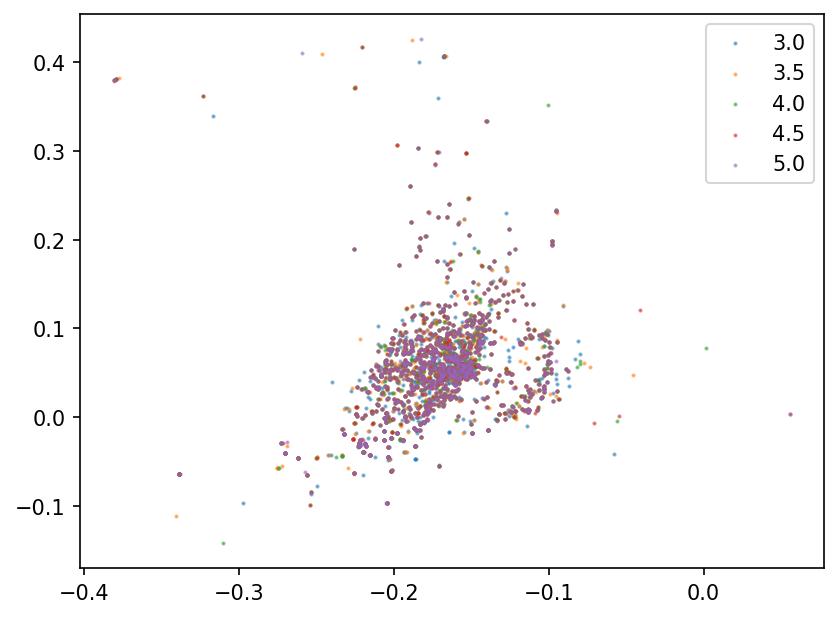

In [114]:
# zoom in and look for clusters
# trace families by making clones and varying mean anomoly and longitude of ascending node
# find which clones overlap with the observed locations/times and see if that corresponds to clusters

fig = plt.figure(dpi=150)
for group in filtered_data.group_by("snr").groups:
    plt.scatter(group['v_ra'], group['v_dec'], label=group[0]['snr'], s=1, alpha=0.5)
# plt.hist(data['mag'], bins='auto', density=True, alpha=0.5)
plt.legend()
plt.show()

In [115]:
filtered_data[filtered_data['snr'] == 3.0]

collection,snr,detector,cluster,mag,n,v_ra,v_dec
,,,,,,deg / d,deg / d
object,float64,int64,int64,float64,int64,float64,float64
DEEP/20190403/A0c,3.0,1,0,23.868853953454547,16,-0.2154584210240494,0.040247500392335336
DEEP/20190403/A0c,3.0,1,33,18.531679353052027,94,-0.1584493463352412,0.09633880908658919
DEEP/20190403/A0c,3.0,1,31,21.877447979500786,102,-0.18406864807677203,0.04179512977881571
DEEP/20190403/A0c,3.0,1,34,22.650261769249617,102,-0.16490638428938445,0.05546024778830318
DEEP/20190403/A0c,3.0,1,35,23.653774134957565,95,-0.16563333672139466,0.09496617027795592
DEEP/20190403/A0c,3.0,1,37,21.838952428305888,104,-0.1500856216248014,0.10377127461260814
DEEP/20190403/A0c,3.0,1,36,23.08472480914783,100,-0.16667389628996118,0.07039586676110167
DEEP/20190403/A0c,3.0,1,38,22.663731847999088,92,-0.15383169403633437,0.0612817274354136
